In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pysal.lib.io
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
from pyproj import Proj, transform
%matplotlib inline

In [4]:
# Loading datasets
master_df = pd.read_csv('./data/master.csv')
threat_df = pd.read_csv('./data/threat.csv')

## Loads geographic data from https://data.ca.gov/dataset/ca-geographic-boundaries
ca_places = gpd.read_file('./data/CA_places/CA_Places_TIGER2016.shp')
ca_state = gpd.read_file('./data/CA_State/CA_State_TIGER2016.shp')
ca_counties = gpd.read_file('./data/CA_Counties/CA_Counties_TIGER2016.shp')

## Reset INTPTLAT & INTPTLON to floats
ca_places['INTPTLAT'] = ca_places['INTPTLAT'].astype('float')
ca_places['INTPTLON'] = ca_places['INTPTLON'].astype('float')
ca_state['INTPTLAT'] = ca_state['INTPTLAT'].astype('float')
ca_state['INTPTLON'] = ca_state['INTPTLON'].astype('float')
ca_counties['INTPTLAT'] = ca_counties['INTPTLAT'].astype('float')
ca_counties['INTPTLON'] = ca_counties['INTPTLON'].astype('float')

## Reset places dataframe to capital NAME
for i, row in enumerate(ca_places.iterrows()):
    ca_places.loc[i,'NAME'] = row[1]['NAME'].upper()

In [5]:
# Makes the location series a series of lists again
from ast import literal_eval
master_df['location'] = master_df['location'].apply(literal_eval)

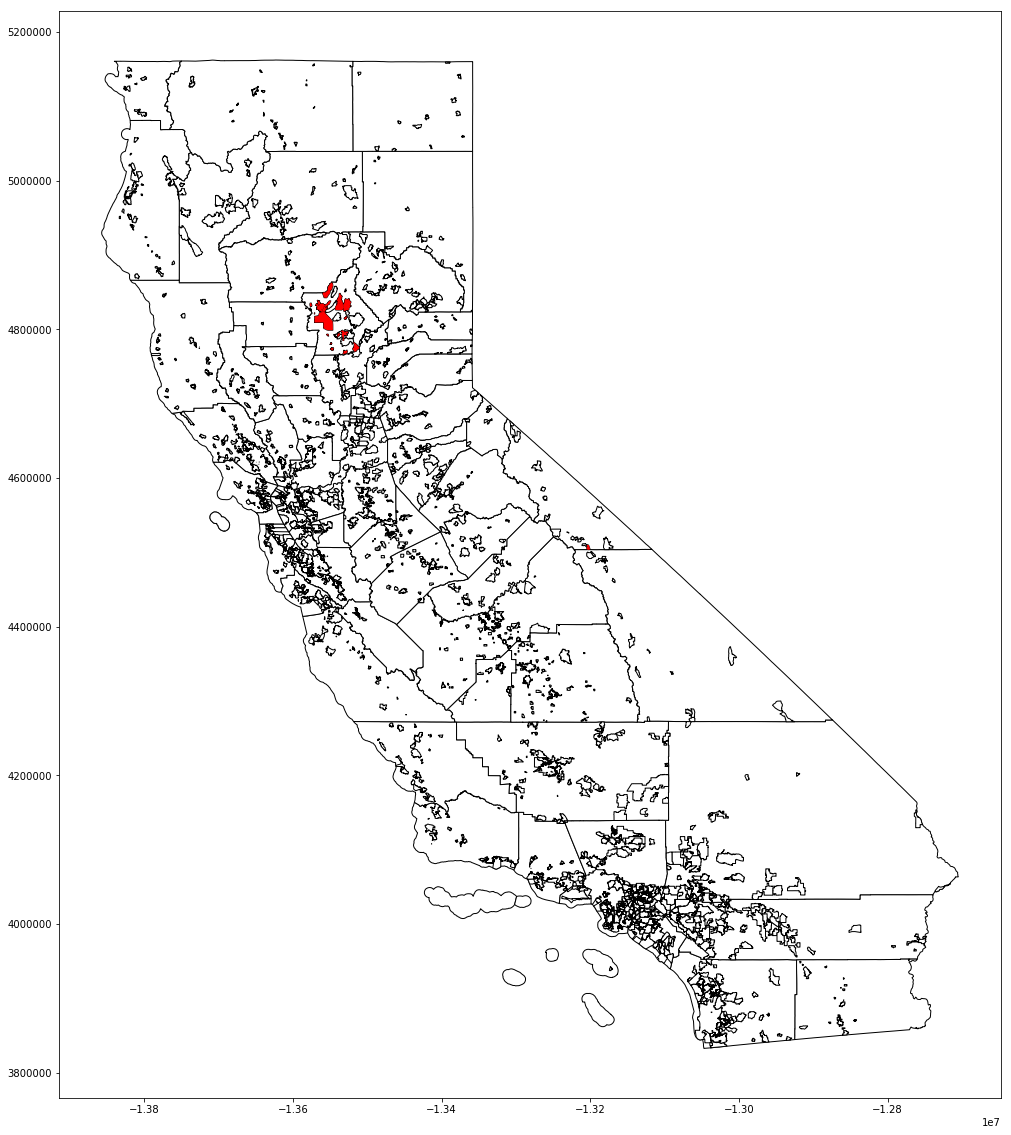

In [6]:
# Empty list to house all identified locations
locations = []

# Fills locations list with all locations identified
for locs in master_df['location']:
    for loc in locs:
        locations.append(loc.upper())

# Removes duplicates from the list of locations
locations = list(set(locations))

# Plots the county and city outlines
county = ca_counties.plot(color='white', edgecolor='black', figsize=(20,20));
cities = ca_places.plot(color='white', edgecolor='black', ax=county);

# Colors in the locations where threats were identified
for row in ca_places.iterrows():
    if row[1]['NAME'] in locations:
        ca_places[ca_places['NAME'] == row[1]['NAME']].plot(color='r', ax = cities)

In [7]:
# Sets the output name
output_file("gmap.html")

# Sets the initial view for the Google Map (location, map type, zoom level)
map_options = GMapOptions(lat=39.5138, lng=-121.5564, map_type="roadmap", zoom=8)

# Creates google map
p = gmap("GOOGLEAPIKEY", map_options, title="California")

# Adds data to identify the locations of all threats identified
source = ColumnDataSource(
    data=dict(lat=threat_df['latitude'],
              lon=threat_df['longitude'])
)

# Creates circles for each threat
p.circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, source=source)

# Exports the Google map
show(p)